# Fourier Space Filtering Based on FRC

Here I show hot to do frequency domain denoising based on FRC

In [1]:
%matplotlib inline

import os
import numpy as np

import miplib.ui.plots.image as showim
import miplib.data.io.read as imread
import miplib.processing.image as imops
from miplib.data.containers.image import Image

import miplib.analysis.resolution.fourier_ring_correlation as frc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection

import miplib.ui.plots.frc as frcplots
from miplib.processing.fft_filters import fft_filter, butterworth_fft_filter, gaussian_fft_filter
from miplib.ui.cli import miplib_entry_point_options as options

import urllib.request as dl


## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. You can find the image [here](https://doi.org/10.6084/m9.figshare.8159180.v1)

In [2]:
# Image
data_dir = os.getcwd()
filename = "FRC_GaAsP_AU04_.nd2"
full_path = os.path.join(data_dir, filename)

# Automatically dowload the file from figshare, if necessary.
if not os.path.exists(full_path):
        dl.urlretrieve("https://ndownloader.figshare.com/files/15203147", full_path)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print ("The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing))

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


## Setup

I expose some options for the FRC here. None of them you typically have to touch, but naturally can, e.g. to adjust the binning or the threshold.

In [3]:
args_list = ("None --bin-delta=1  --frc-curve-fit-type=smooth-spline "  
             " --resolution-threshold-criterion=fixed").split()
            
args = options.get_frc_script_options(args_list)

print (args)


Namespace(carma_det_idx=0, carma_gate_idx=0, channel=0, d_angle=20, d_bin=1, d_extract_angle=5.0, debug=False, directory='None', disable_hamming=False, evaluate_results=False, frc_curve_fit_degree=8, frc_curve_fit_type='smooth-spline', frc_mode='one-image', hollow_iterator=False, jupyter=False, min_filter=False, pathout=None, plot_size=(2.5, 2.5), resol_square=False, resolution_point_sigma=0.01, resolution_snr_value=0.25, resolution_threshold_criterion='fixed', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.14285714285714285, save_plots=False, scale=100, show_image=False, show_plots=False, temp_dir=None, test_drive=False, verbose=False, working_directory='/home/sami/Data')


## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

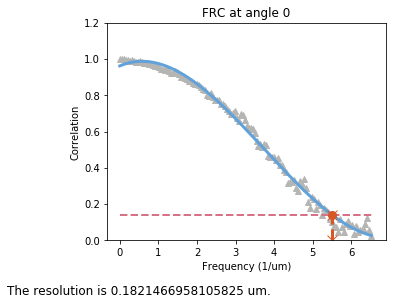

In [4]:
frc_results = FourierCorrelationDataCollection()


frc_results[0] = frc.calculate_single_image_frc(image, args)

plotter = frcplots.FourierDataPlotter(frc_results)
plotter.plot_one(0)


## Ideal Filter

In the first filtering alternative I just simply remove all the frequencies beyond the cut-off point. If you are using two-image FRC, the threshold point is the same as the FRC cut-off point, which you can get directly from the FRC result with the *resolution-point* key. In the case of one-image FRC, the point in the full-size image has to be calculated, e.g. as in here.

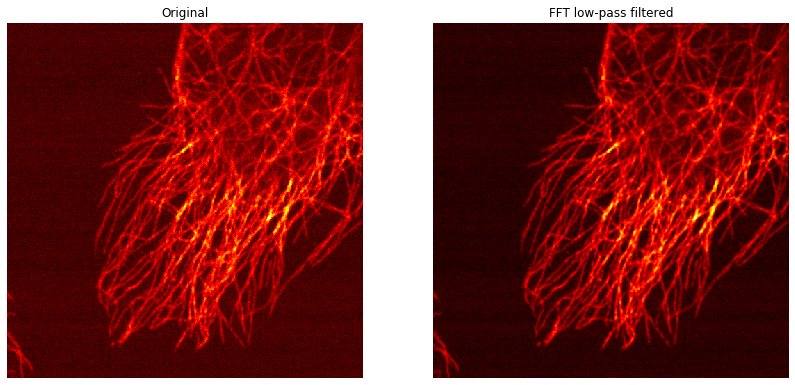

In [5]:
# Get frequency domain cut-off point from FRC resolution
frc_resolution = frc_results[0].resolution['resolution']
threshold_point = 2 * image.spacing[0] / frc_resolution


# Run the filter
ideal_result = fft_filter(image, 
                    threshold_point)

showim.display_2d_images(image, 
                         ideal_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")


## Butterworth

The second type of a low-pass filter is a Butterworth filter. It also work well, but is not able to remove all the noise.

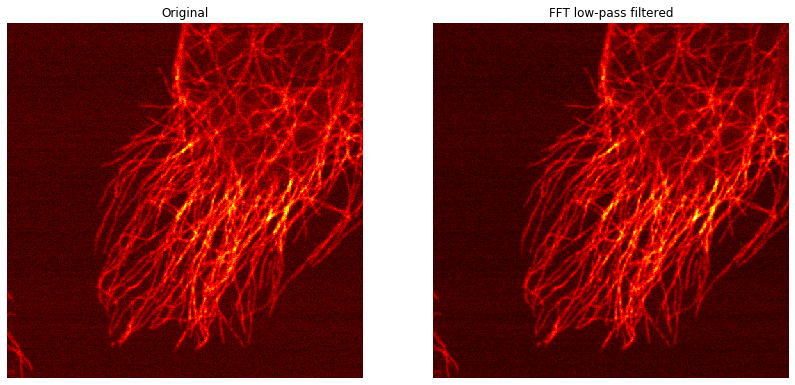

In [6]:
butterworth_result = butterworth_fft_filter(image, 
                    threshold_point, n=3)

showim.display_2d_images(image, 
                         butterworth_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")


## Gaussian


The Gaussian filter works ok as well. It does seem to blur the details a little bit, and is not able to remove all the noise -- but that was expected.

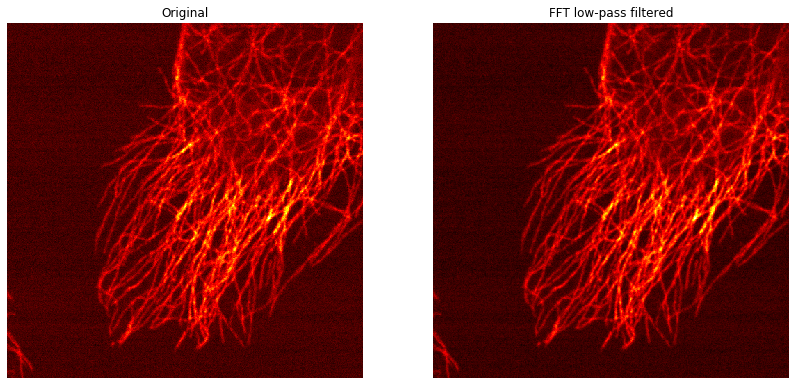

In [7]:
gaussian_result = gaussian_fft_filter(image, threshold_point)

showim.display_2d_images(image, 
                         gaussian_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")

